In [1]:

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib widget
log_folder = 'runs'

from matplotlib import rc
### for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
# rc('axes', titlesize=16)
# rc('axes', labelsize=16)
# rc('axes', axisbelow=False)
# rc('lines',linewidth=1.5)
# # lines.markersize : 10
# rc('xtick', labelsize=16)
# rc('xtick.major',size=10)
# rc('xtick.minor',size=5)
# rc('xtick',direction='in')
# rc('ytick', labelsize=16)
# rc('ytick.major',size=10)
# rc('ytick.minor',size=5)
# rc('ytick',direction='in')
# rc('legend',fontsize='large')
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)


from jax.scipy.ndimage import map_coordinates

# the trapz integration has been moved from jnp to jax.scipy
# in newer versions of jax, and might disappear altogether
if hasattr(jnp,'trapz'):
  integrate_trapz = jnp.trapz
else:
  integrate_trapz = jax.scipy.integrate.trapezoid

/home/ohahn/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# import os
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [3]:
from pylinger_background import evolve_background
from pylinger_perturbations import evolve_perturbations, power_Kaiser, get_power, get_aprimeoa

In [4]:
## Cosmological Parameters

## Cosmological Parameters
Tcmb    = 2.7255
YHe     = 0.248
Omegam  = 0.32
Omegab  = 0.05
w_DE_0  = -0.9999
w_DE_a  = 0.00
cs2_DE  = 0.9999
num_massive_neutrinos = 1
mnu     = 0.06  #eV
Tnu     = (4/11)**(1/3) #0.71611 # Tncdm of CLASS
Neff    = 3.046 # -1 if massive neutrino present
N_nu_mass = 1
N_nu_rel = Neff - N_nu_mass * (Tnu/((4/11)**(1/3)))**4
standard_neutrino_neff=Neff+num_massive_neutrinos
h      = 0.67
A_s     = 2.1064e-09
n_s     = 0.96
sigmaz  = 0.03 #3 #0.03  # redshift error
sigma8  = 0.816
Psz     = 0.0
b       = 1.6

# list of parameters with respect to which we take derivatives
fieldnames = ['h', '\\Omega_m', '\\Omega_b', 'N_{eff}', 'm_{\\nu}', 'T_{CMB}', 'Y_{He}', '\\sigma_8', 'n_s', 'w_0', 'w_a', 'c_s^2', 'b1', '\\sigma_z', 'P_s(z)']
fiducial_cosmo_param = jnp.array([h, Omegam, Omegab, N_nu_rel, mnu, Tcmb, YHe, sigma8, n_s,  w_DE_0, w_DE_a, cs2_DE, b, sigmaz, Psz])

# all variables that should be included in the Fisher matrix
selected_vars = [1,2,9,10,0,8,7]#,14]
# all variables to be plotted, all others 
plot_vars     = [1,2,9,10,0,8,7]

# cut in k (kmax = 0.3 h/Mpc for optimistic, kmax = 0.25 h/Mpc for pessimistic)
kmax_cut = 0.30

# modes to sample
nmodes = 512
nmu    = 256
kmin   = 2e-5  # in h/Mpc
kmax   = 10.0  # in h/Mpc


Angular Diameter Distance
$$ D_A(a) = a \int_{t(a)}^{t(1)} \frac{c}{a(t)} {\rm d}t = a \int_a^1 \frac{c}{a\mathcal{H}(a)} {\rm d}a $$

Alcock-Paczynski deformations
$$ \begin{align}
k_\perp &= \frac{k_{\perp,\text{ref}}}{q_\perp} & k_\parallel &= \frac{k_{\parallel,\text{ref}}}{q_\parallel} \\
q_\perp(z) &= \frac{D_A(z)}{D_{A,\text{ref}}(z)} & q_\parallel(z) &= \frac{H_\text{ref}(z)}{H(z)} \\
k(k_\text{ref},\mu_\text{ref}) &= \frac{k_\text{ref}}{q_\perp}\left[ 1+ \mu_\text{ref}^2\left(\frac{q_\perp^2}{q_\parallel^2}-1\right)\right]^\frac{1}{2} &
\mu(\mu_\text{ref}) &= \mu_\text{ref}\frac{q_\perp}{q_\parallel} \left[1+\mu_\text{ref}^2\left(\frac{q_\perp^2}{q_\parallel^2}-1\right)\right]^{-\frac{1}{2}}
\end{align}$$

In [5]:
def get_param_from_args( args ):
    param = {}
    param['h']      = args[0]
    param['Omegam'] = args[1]
    param['Omegab'] = args[2]
    param['Omegak'] = 0.0
    param['A_s']    = 2.1064e-09
    param['n_s']    = args[8]
    param['H0']     = args[0]*100
    param['Tcmb']   = args[5]
    param['YHe']    = args[6]
    param['Neff']   = args[3] 
    param['Nmnu']   = num_massive_neutrinos
    param['mnu']    = args[4]
    param['w_DE_0'] = args[9]
    param['w_DE_a'] = args[10]
    param['cs2_DE'] = args[11]
    param['sigma8'] = args[7]
    param['k_p']    = 0.05
    param['sigma_z0'] = args[13]
    param['P_s_z'] = args[14]

    ## Compute Background evolution
    param = evolve_background(param=param, thermo_module='RECFAST')

    return param

def compute_angular_diameter( aexp, param ):
    aexpv = jnp.linspace( aexp, 1.0, 100 )
    H = get_aprimeoa( param=param, aexp=aexpv ) * aexpv
    Da = aexp * integrate_trapz( 1/H, aexpv)
    return Da

# @jax.jit
# Compute the observed power spectrum including Alcock-Paczynski 
def Pkmu_of_cosmo( args, *, aexp, bias, args_fiducial ):
    """ Compute the matter power spectrum for a given set of cosmological parameters"""
    param = get_param_from_args(args)
    h = param['h']
    
    # evolve modes to aexp and a=1.0
    aexp_out = jnp.array([aexp, 1.0])
    y, kmodes = evolve_perturbations( param=param, kmin=kmin*h, kmax=kmax*h, num_k=nmodes, aexp_out=aexp_out, rtol=1e-4, atol=1e-4 )

    # compute sigma8 normalisation 
    Pm0 = get_power( k=kmodes, y=y[:,-1,:], param=param, idx=4 )
    Wth = lambda kR : 3*(jnp.sin(kR)-kR*jnp.cos(kR))/(kR)**3
    dsigma = Wth(kmodes/h*8.0)**2 * Pm0 * kmodes**3
    sigma8_2_measured = integrate_trapz( y=(dsigma), x=jnp.log(kmodes) ) / (2*jnp.pi**2)
    
    # compute redshift-space spectrum using Kaiser formula, need fiducial cosmology parameters 
    # so that photo-z cutoff does not depend on expansion history 
    param_fiducial = get_param_from_args(args_fiducial)
    Pkmu, mu = power_Kaiser( y=y[:,0,:], kmodes=kmodes, bias=bias, aexp=aexp_out[0], nmu=nmu, param=param )
    
    # normalise to correct sigma_8
    Pkmu *= param['sigma8']**2 / sigma8_2_measured

    # change units of power spectrum to (Mpc/h)**3, where h is not the reference value
    Pkmu *= h**3 
    
    # compute Alcock-Paczynski 
    Da = compute_angular_diameter( aexp, param )
    Da_fiducial = compute_angular_diameter( aexp, param_fiducial )
    Ha = get_aprimeoa( param=param, aexp=aexp)
    Ha_fiducial = get_aprimeoa( param=param_fiducial, aexp=aexp)

    qperp = Da/Da_fiducial
    qpara = Ha_fiducial/Ha

    # evaluate at observed k,µ
    logkmodes = jnp.log(kmodes)
    kobs   = kmodes[:,None] / qperp * jnp.sqrt(1 + mu[None,:]**2 * (qperp**2/qpara**2-1))
    muobs  = mu[None,:] * qperp/qpara / jnp.sqrt(1 + mu[None,:]**2 * (qperp**2/qpara**2-1)) * jnp.ones((nmodes,nmu))
    ikobs  = (jnp.log(kobs) - jnp.min(logkmodes))/(jnp.max(logkmodes)-jnp.min(logkmodes)) * nmodes
    imuobs = (muobs - jnp.min(mu))/(jnp.max(mu)-jnp.min(mu)) * nmu
    Pkmu   = map_coordinates( Pkmu, (ikobs.flatten(),imuobs.flatten()), order=1 ).reshape((nmodes,nmu))

    # Pkmu = Pkmu.at[ kmodes > kmax_cut * h ].set(0.0)

    # photo-z error, cut-off position does not depend on expansion history
    # consider this remark from arXiv:1910.09273
    #  "We note that the damping due to redshift errors does not vary with changes in the 
    #   expansion history, since k_\parallel \propto H(z) and \sigma_r \propto 1/H(z)"
    # so H=aprimeoa is the fiducial one, but kmodes also needs to be rescaled by k/h*h_fiducial
    Fkmu = jnp.exp( -(kmodes[:,None] / qpara / Ha )**2 * mu[None,:]**2 * param['sigma_z0']**2 )
    Pkmu *= Fkmu
    
    # apply Alcock-Pacinski Jacobian
    Pkmu *= 1. / (qperp**2 * qpara)
    
    # add shot noise
    # Pkmu += param['P_s_z']

    return jnp.log(Pkmu), Pkmu, mu, kmodes/h
    


In [6]:
Vs_bin   = [7.94e9, 9.15e9, 10.05e9, 16.22e9]  # Vs_bin has units Mpc**3 / h**3
Dz_bin   = [0.2, 0.2, 0.2, 0.3]                # unitless
dNdOmega = [1815.0, 1701.5, 1410.0, 940.97]    # units are 1/deg**2 
bias     = [1.46, 1.61, 1.75, 1.90]
zmean    = [1.00, 1.20, 1.40, 1.65]

def effective_volume(Pkmu, nbin ):
    Vs = Vs_bin[nbin] 
    nz = dNdOmega[nbin] * 15000 / Vs * Dz_bin[nbin]  
    Veff = Vs * (nz * Pkmu  / (nz * Pkmu  + 1))**2
    return Veff

In [7]:
logPkmu = {}; Pkmu = {}; mu = {}; kmodes = {}; dlogPkmu = {}; dPkmu = {}

dPkmu_dcosmo = jax.jacfwd( Pkmu_of_cosmo )

for i,(z,b) in enumerate(zip(zmean,bias)):
  print('running redshift bin ', i, ' <z> = ', z, ' b = ', b)
  logPkmu[i], Pkmu[i], mu[i], kmodes[i] = Pkmu_of_cosmo( fiducial_cosmo_param, args_fiducial=fiducial_cosmo_param, aexp = 1./(1.+z), bias = b )
  dlogPkmu[i], dPkmu[i],_,_ = dPkmu_dcosmo( fiducial_cosmo_param, args_fiducial=fiducial_cosmo_param, aexp = 1./(1.+z), bias = b )

running redshift bin  0  <z> =  1.0  b =  1.46
running redshift bin  1  <z> =  1.2  b =  1.61
running redshift bin  2  <z> =  1.4  b =  1.75
running redshift bin  3  <z> =  1.65  b =  1.9


In [8]:
## COMPUTE FISHER MATRIX ENTRIES
F = jnp.zeros((len(selected_vars),len(selected_vars)))
for idx in range(4):
    Pkmu_, dlogPkmu_, kmodes_, mu_ = Pkmu[idx], dlogPkmu[idx], kmodes[idx], mu[idx]

    for i,ivar in enumerate(selected_vars): 
        for j,jvar in enumerate(selected_vars):

            Veff = effective_volume(Pkmu_, nbin=idx )

            # product of derivatives
            dPkmu_dcosmo_prod = dlogPkmu_[...,ivar] * dlogPkmu_[...,jvar] 

            # multiply by Veff and remove possible NaNs
            dPkmu_dcosmo_prod *= Veff * kmodes_[:,None]**3
            dPkmu_dcosmo_prod = dPkmu_dcosmo_prod.at[ jnp.isnan(dPkmu_dcosmo_prod) ].set( 0.0 )

            # integrate over mu
            dPk_dcosmo = integrate_trapz( dPkmu_dcosmo_prod, x=mu_, axis=-1 )
            # integrate over k
            F_ij = 1/(8*jnp.pi**2) * integrate_trapz( dPk_dcosmo, x=jnp.log(kmodes_), axis=-1 )

            F = F.at[i,j].add( F_ij )

In [9]:
def plot_uncertainty_ellipse( transform, F, i, j, x0, y0, ax, color='b'):
    """
    Plot uncertainty ellipse given Fisher matrix F.
    
    Parameters:
        - F: Fisher information matrix (2x2 array).
    """

    if transform:
        C = np.linalg.inv(F)
        # Calculate covariance matrix
        Cii, Cjj, Cij = C[i,i], C[j,j], C[i,j]
    else:
        Cii, Cjj, Cij = F[i,i], F[j,j], F[i,j]

    a = jnp.sqrt(jnp.abs((Cii+Cjj)/2 + jnp.sqrt(0.25*(Cii-Cjj)**2 + Cij**2)))  # arXiv:1910.09273, eq. (47)
    b = jnp.sqrt(jnp.abs((Cii+Cjj)/2 - jnp.sqrt(0.25*(Cii-Cjj)**2 + Cij**2)))  # ...
    phi = 0.5 * jnp.arctan2( 2*Cij, Cii-Cjj )                                  # ...

    # confidence region amplitdues, from arXiv:1910.09273, below eq. (47):
    f1 = jnp.sqrt(2.3)   # 1 sigma
    f2 = jnp.sqrt(6.18)  # 2 sigma
    f3 = jnp.sqrt(11.8)  # 3 sigma

    patch = ax.add_patch( Ellipse((x0,y0),f1*a*2,f1*b*2,angle=np.degrees(phi),alpha=0.2, facecolor=color) )
    ax.add_patch( Ellipse((x0,y0),f2*a*2,f2*b*2,angle=np.degrees(phi),alpha=0.2, facecolor=color) )
    
    ax.plot(x0,y0,'k+',lw=0.125,ms=2)

    return patch

In [10]:
# load Euclid collaboration Fisher matrix data
data = np.load('data/fisher_matrix_euclid.npz')
euclid_vars =  ['Omegam', 'Omegab', 'w0', 'wa', 'h', 'ns', 'sigma8']
euclid_reorder = range(7)
Feuclid = data['F']

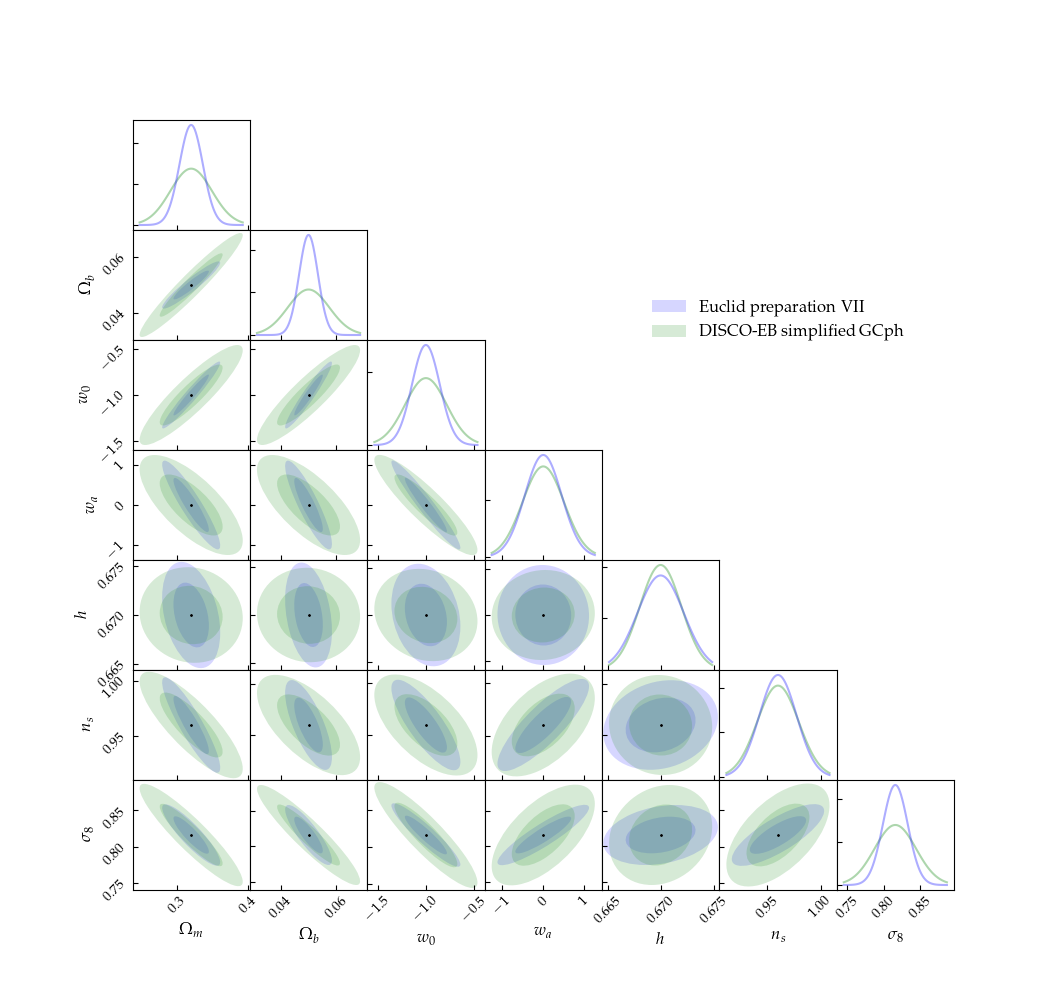

In [17]:
fig, ax = plt.subplots( len(euclid_vars), len(euclid_vars), figsize=(10.6,10), gridspec_kw = {'wspace':0, 'hspace':0})#, layout='constrained')
FF = jnp.linalg.inv(Feuclid)
C = jnp.linalg.inv(F)
Ceuclid = Feuclid
for i, label1 in enumerate(euclid_vars):#[:-1]):
  ivar = selected_vars[i]
  for j, label2 in enumerate(euclid_vars):
    ax[j,i].tick_params(direction="in")
    if i==j:
        # if i==len(euclid_vars)-1:
        #   continue
        # else:
        ax[j,i].set_yticklabels([])
        
        # Plot 1D Gaussian PDF on the diagonal
        x = np.linspace(-np.sqrt(6.18*C[i,i]), np.sqrt(6.18*C[i,i]), 100) + fiducial_cosmo_param[ivar]
        pdf = 1 / np.sqrt(2 * np.pi * C[i, i]) * np.exp(-0.5 * ((x-fiducial_cosmo_param[ivar]) ** 2) / C[i, i])
        ax[j,i].plot(x,pdf,c=[0.2,0.6,0.2],alpha=0.4)
        pdf = 1 / np.sqrt(2 * np.pi * Ceuclid[i, i]) * np.exp(-0.5 * ((x-fiducial_cosmo_param[ivar]) ** 2) / Ceuclid[i, i])
        ax[j,i].plot(x,pdf,c=[0.2,0.2,1],alpha=0.4)

        if j==len(euclid_vars)-1:
          ax[j,i].set_xlabel(f'${fieldnames[ivar]}$', size=12)
          ax[j,i].tick_params(axis='x', rotation=45)
        else:
          ax[j,i].set_xticklabels([])

    if i<j:
      jvar = selected_vars[j]
      patch1 = plot_uncertainty_ellipse( False, Feuclid, euclid_reorder[i], euclid_reorder[j], fiducial_cosmo_param[ivar], fiducial_cosmo_param[jvar], ax[j,i], color=[0.2,0.2,1] )
      patch2 = plot_uncertainty_ellipse( True, F, i, j, fiducial_cosmo_param[ivar], fiducial_cosmo_param[jvar], ax[j,i], color=[0.2,0.6,0.2] )

      if (i==0)&(j==1):
        # loc='upper center', bbox_to_anchor=(0.5, 0.5),
        ax[i,j].legend( [patch1,patch2], ['Euclid preparation VII','DISCO-EB simplified'], loc='upper center', bbox_to_anchor=(4.5, -0.5), fontsize='large', frameon=False)

      if (i==0):
        ax[j,i].set_ylabel(f'${fieldnames[jvar]}$', size=12)
        ax[j,i].tick_params(axis='y', rotation=45)
      else:
        ax[j,i].set_yticklabels([])

      if j==len(euclid_vars)-1:
        ax[j,i].set_xlabel(f'${fieldnames[ivar]}$', size=12)
        ax[j,i].tick_params(axis='x', rotation=45)
      else:
        ax[j,i].set_xticklabels([])
      
    ax[j,i].tick_params(axis='both', which='both')#, labelsize=5)
      
    if i>j:
      ax[j,i].axis('off')

for i, label1 in enumerate(euclid_vars):#[:-1]):
  ivar = selected_vars[i]
  for j, label2 in enumerate(euclid_vars):
    jvar = selected_vars[j]
    # ax[j,i].set_xlim(fiducial_cosmo_param[ivar]-np.sqrt(6.18*C[i,i]),fiducial_cosmo_param[ivar]+np.sqrt(6.18*C[i,i]))
    ax[j,i].set_xlim(fiducial_cosmo_param[ivar]-np.sqrt(8*C[i,i]),fiducial_cosmo_param[ivar]+np.sqrt(8*C[i,i]))

# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
# ax[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, 0.5))